<a href="https://www.kaggle.com/code/giuliobenedetti/ml-for-parkinson?scriptVersionId=163478238" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import os

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers

In [2]:
# If TPU is available
try:
    # Detect TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())

except:
    tpu = None
    

# If TPU is defined
if tpu:
    # Initialise TPU
    tf.tpu.experimental.initialize_tpu_system(tpu)
    # Instantiate a TPU distribution strategy
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

else:
    # Or instanstiate available strategy
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2024-02-19 20:18:29.077347: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-19 20:18:29.077451: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-19 20:18:29.077589: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-19 20:18:29.077659: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-19 20:18:29.077726: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-19 20:18:29.077933: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-19 20:18:29.078000: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


In [3]:
base_dir = "/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/"
tdcsfog_dir = base_dir + "train/tdcsfog/"

samples = []

# Read in samples
for file in os.listdir(tdcsfog_dir):
    samples.append(pd.read_csv(tdcsfog_dir + file, index_col=0))

m = len(samples)
print(f"Size of Train Set: {m}")

Size of Train Set: 833


In [4]:
patches = []
window = 1000
step = 100
stride = 1

for sample in samples:
    
    pad_idx = step - (sample.shape[0] - window) % step
    padded_sample = pd.concat([sample, sample[:pad_idx]])

    for i in range((padded_sample.shape[0] - window) // step):
        patch = padded_sample[i * step:i * step + window:stride]
        patches.append(patch)

train_ds = np.array(patches)

In [5]:
# Store feature columns into X array
raw_X_train = train_ds[:, :, :3]
# Store target columns into y array
y_train = train_ds[:, :, 3:]

input_shape = raw_X_train[0].shape
print(f"Input Shape: {input_shape}")

Input Shape: (1000, 3)


In [6]:
# Find triplette of minima for every sample
min_arr = np.min(raw_X_train, axis=1, keepdims=True)
# Find triplette of maxima for every sample
max_arr = np.max(raw_X_train, axis=1, keepdims=True)
# Normalise with MinMax rescaling
X_train = (raw_X_train - min_arr) / (max_arr - min_arr)

print(f"Min and Max before Norm: {np.min(raw_X_train):.1f} and {np.max(raw_X_train):.1f}")
print(f"Min and Max after Norm: {np.min(X_train)} and {np.max(X_train)}")

Min and Max before Norm: -47.8 and 30.3
Min and Max after Norm: 0.0 and 1.0


In [7]:
print("Input Example:")
print("\n")

print("Feature series:")
print(X_train[0])
print("\n")

print("Target series:")
print(y_train[0])

Input Example:


Feature series:
[[0.80972592 0.62726031 0.54776468]
 [0.61033044 0.70692165 0.54709902]
 [0.68662042 0.52055498 0.60849153]
 ...
 [0.7056061  0.47347907 0.67110852]
 [0.6136766  0.46268715 0.63756049]
 [0.44412337 0.3631933  0.70023879]]


Target series:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [8]:
# Set up model within scope of tpu strategy
with strategy.scope():

    # Design LSTM model with one recurrent layer
    model = keras.Sequential([
        layers.LSTM(32, return_sequences=True),
        layers.Dense(3, activation="softmax")
    ])

    # Compile model
    model.compile(
        optimizer="adam",
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["categorical_accuracy", keras.metrics.Precision()]
    )

2024-02-19 20:19:05.878337: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


In [9]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    verbose=True
)

# Store training history as a dataframe
history_df = pd.DataFrame(history.history)

print(f"Train loss: {history_df['loss'].iloc[-1]:.3f}")
print(f"Train accuracy: {history_df['categorical_accuracy'].iloc[-1]:.3f}")

Epoch 1/20


2024-02-19 20:19:10.661247: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-19 20:19:10.680821: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-19 20:19:10.699802: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-19 20:19:10.719652: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-19 20:19:10.739943: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-19 20:19:10.760655: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-19 20:19:10.780122: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

  2/883 [..............................] - ETA: 44s - loss: 0.3763 - categorical_accuracy: 0.1541 - precision: 0.0000e+00    

2024-02-19 20:19:17.846344: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-19 20:19:17.846445: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-19 20:19:17.846553: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-19 20:19:17.846663: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-19 20:19:17.846756: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-19 20:19:17.846876: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-19 20:19:17.846973: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

112/883 [==>...........................] - ETA: 35s - loss: 0.2818 - categorical_accuracy: 0.2730 - precision: 0.2752

2024-02-19 20:19:22.878048: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-19 20:19:22.878240: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


221/883 [======>.......................] - ETA: 30s - loss: 0.2827 - categorical_accuracy: 0.2742 - precision: 0.2753

2024-02-19 20:19:27.912729: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


330/883 [==========>...................] - ETA: 25s - loss: 0.2795 - categorical_accuracy: 0.2702 - precision: 0.2707

2024-02-19 20:19:32.943729: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


558/883 [=================>............] - ETA: 14s - loss: 0.2783 - categorical_accuracy: 0.2714 - precision: 0.2718

2024-02-19 20:19:43.459024: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


632/883 [====================>.........] - ETA: 11s - loss: 0.2783 - categorical_accuracy: 0.2726 - precision: 0.2730

2024-02-19 20:19:46.862239: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


883/883 [==============================] - 56s 56ms/step - loss: 0.2793 - categorical_accuracy: 0.2724 - precision: 0.2728 - val_loss: 0.3166 - val_categorical_accuracy: 0.2137 - val_precision: 0.2139
Epoch 2/20
883/883 [==============================] - 43s 49ms/step - loss: 0.2771 - categorical_accuracy: 0.2726 - precision: 0.2728 - val_loss: 0.3157 - val_categorical_accuracy: 0.2137 - val_precision: 0.2139
Epoch 3/20
883/883 [==============================] - 43s 49ms/step - loss: 0.2774 - categorical_accuracy: 0.2728 - precision: 0.2728 - val_loss: 0.3166 - val_categorical_accuracy: 0.2139 - val_precision: 0.2139
Epoch 4/20
883/883 [==============================] - 43s 49ms/step - loss: 0.2764 - categorical_accuracy: 0.2728 - precision: 0.2728 - val_loss: 0.3172 - val_categorical_accuracy: 0.2139 - val_precision: 0.2139
Epoch 5/20
883/883 [==============================] - 43s 49ms/step - loss: 0.2760 - categorical_accuracy: 0.2728 - precision: 0.2728 - val_loss: 0.3142 - val_cate

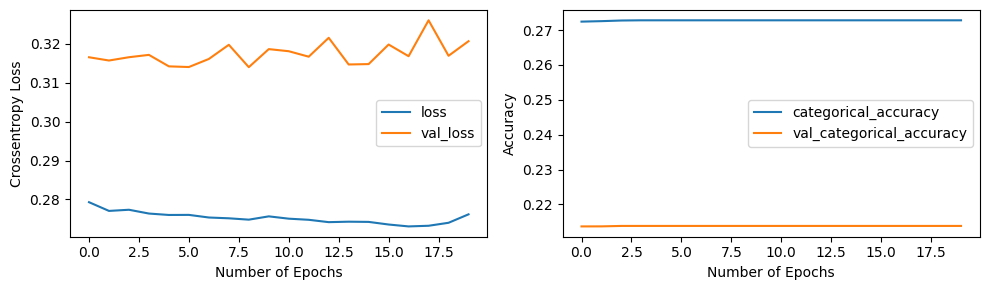

In [10]:
fig, axes = plt.subplots(1, 2)

fig.set_figheight(3)
fig.set_figwidth(10)

# Visualise performance
history_df.loc[:, ["loss", "val_loss"]].plot(ax=axes[0])
axes[0].set_xlabel("Number of Epochs")
axes[0].set_ylabel("Crossentropy Loss")

history_df.loc[:, ["categorical_accuracy", "val_categorical_accuracy"]].plot(ax=axes[1])
axes[1].set_xlabel("Number of Epochs")
axes[1].set_ylabel("Accuracy")

plt.tight_layout()

In [11]:
model.save("/kaggle/working/lstm.keras")

In [12]:
# Store test id
test_id = "003f117e14"
# Read in test session
test_sample = pd.read_csv(base_dir + "test/tdcsfog/" + test_id + ".csv")

# Predict labels
y_pred = model.predict(test_sample.drop("Time", axis=1).to_numpy().reshape(1, -1, 3))

print(f"Predicted time points: {y_pred.shape[1]}")
print("Example Predictions:")
print(y_pred)

2024-02-19 20:33:51.156562: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 3s 3s/step
Predicted time points: 4682
Example Predictions:
[[[0.3456173  0.32403553 0.3303472 ]
  [0.3456173  0.32403553 0.3303472 ]
  [0.3456173  0.32403553 0.3303472 ]
  ...
  [0.3456173  0.32403553 0.3303472 ]
  [0.3456173  0.32403553 0.3303472 ]
  [0.3456173  0.32403553 0.3303472 ]]]
